# 0 Business Undestanding

## Motivação
### Qual o contexto?
O CFO requisitou essa solução em uma reunião de resultados mensais aos gerentes
## Causa raiz do problema
### Por que fazer uma previsão de venda?
Investimento em reformas nas lojas
## Dono do problema
### Quem será o stakeholder?
CFO / alguem que conheça o problema
## Formato da solução
### Qual formato da solução ?
* Granularidade - previsão em R$ nas proximas 6 semanas
* Tipo do problema - previsão de venda / demanda
* Potenciais métodos - time series - regressao - redes neurais - deep learning
* Formato da entrega - previsão das vendas nas proximas 6 semana via celular

## Data fields

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Analise Descritiva

# 0.0 Imports

In [2]:
import math
import pandas as pd
import inflection
import numpy as np

import seaborn as sns

from IPython.core.display import HTML

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [4]:
df_sales_row = pd.read_csv("./data/train.csv", low_memory=False )
df_store_row = pd.read_csv("./data/store.csv", low_memory=False )

#merge
df_row = pd.merge(df_sales_row, df_store_row, how="left", on="Store")

In [5]:
df_row.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
397103,1001,7,2014-07-13,0,0,0,0,0,0,c,a,19640.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


# 1.0 Descricao dos dados


## 1.1 Rename columns

In [6]:
df1 = df_row.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snackcase = lambda x: inflection.underscore(x)

cols_new = list(map(snackcase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimmensions


In [9]:
print(f'Numero de linhas: {df1.shape[0]}')
print(f'Numero de colunas: {df1.shape[1]}')

Numero de linhas: 1017209
Numero de colunas: 18


## 1.3 Data types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

## Formas de trabalhar com N/A
1 Exclusão: 
    * vantagem: rapido
    * desvantagem: perde informação
2 Machine learning 
    * substituição baseado no comportamento da coluna (media/ mediana/ clusterização)
3 Pensando no negócio
    * Como gerou este N/A? 
    

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
760119,475,1,2013-08-19,5086,862,1,0,0,1,a,a,140.0,9.0,2005.0,0,NaN,NaN,NaN


In [13]:
#competition_distance 
## Se esta coluna esta NA pode ser que a distancia entre o concorrente é muito grande, não sendo reconhecida dentro do sistema como um concorrente.
## Para substituir este dado usaremos o um valor maior que a maior distancia presente nos dados, o que significa que não tem um competidor proximo 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.sample(5).T

,176281,246612,717794,519559,423079
store,112,1053,520,755,165
day_of_week,1,7,4,7,2
date,2015-02-23 00:00:00,2014-12-21 00:00:00,2013-09-26 00:00:00,2014-03-23 00:00:00,2014-06-17 00:00:00
sales,5984,0,2936,0,4483
customers,780,0,351,0,452
open,1,0,1,0,1
promo,0,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,a,a,a,d,a


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Data types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [19]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
111765,0,a,c,"Mar,Jun,Sept,Dec",Apr
180999,0,d,a,"Jan,Apr,Jul,Oct",Fev


### 1.7.1 Numerical Attributes

In [20]:
#Central Tendency - mean, median
ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion desvio padrão std, min, max, range, skew, kurtosis
dispersion_std = pd.DataFrame(num_attributes.apply(np.std)).T
dispersion_min = pd.DataFrame(num_attributes.apply(min)).T
dispersion_max = pd.DataFrame(num_attributes.apply(max)).T
dispersion_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dispersion_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew() - x.min())).T
dispersion_kurt = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() - x.min())).T

#Concatenate
metrics = pd.concat(
    [dispersion_min, dispersion_max, dispersion_range, ct_mean, ct_median, dispersion_std, dispersion_skew, dispersion_kurt]
).T.reset_index()
metrics.columns = ['features','min','max','range','mean','median','standard','skew','kurtosis']

In [21]:
metrics

,features,min,max,range,mean,median,standard,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.000955,-2.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-0.998407,-2.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,-9.757656,127.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.042076,-2.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-1907.235657,-1775.928696


/Users/rangelvarnier/.pyenv/versions/3.8.6/envs/datascienceemproducao/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

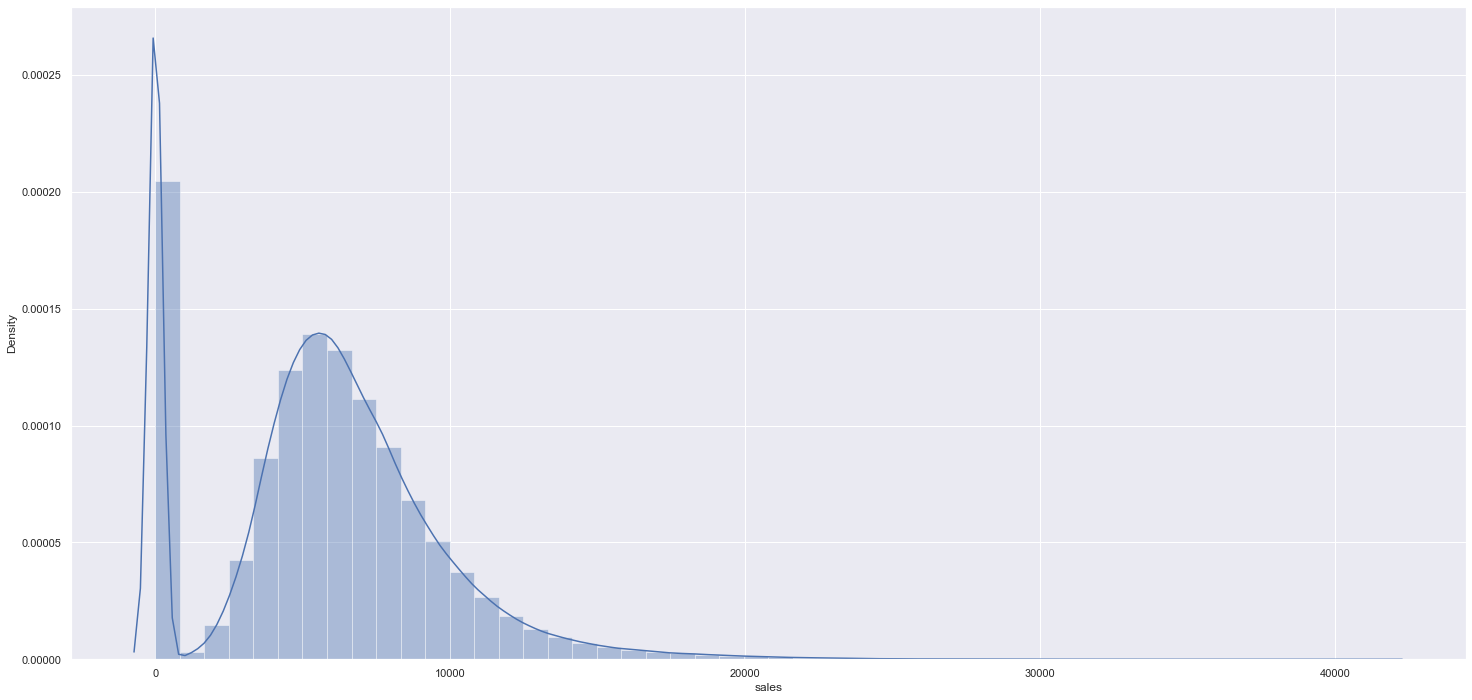

In [22]:
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

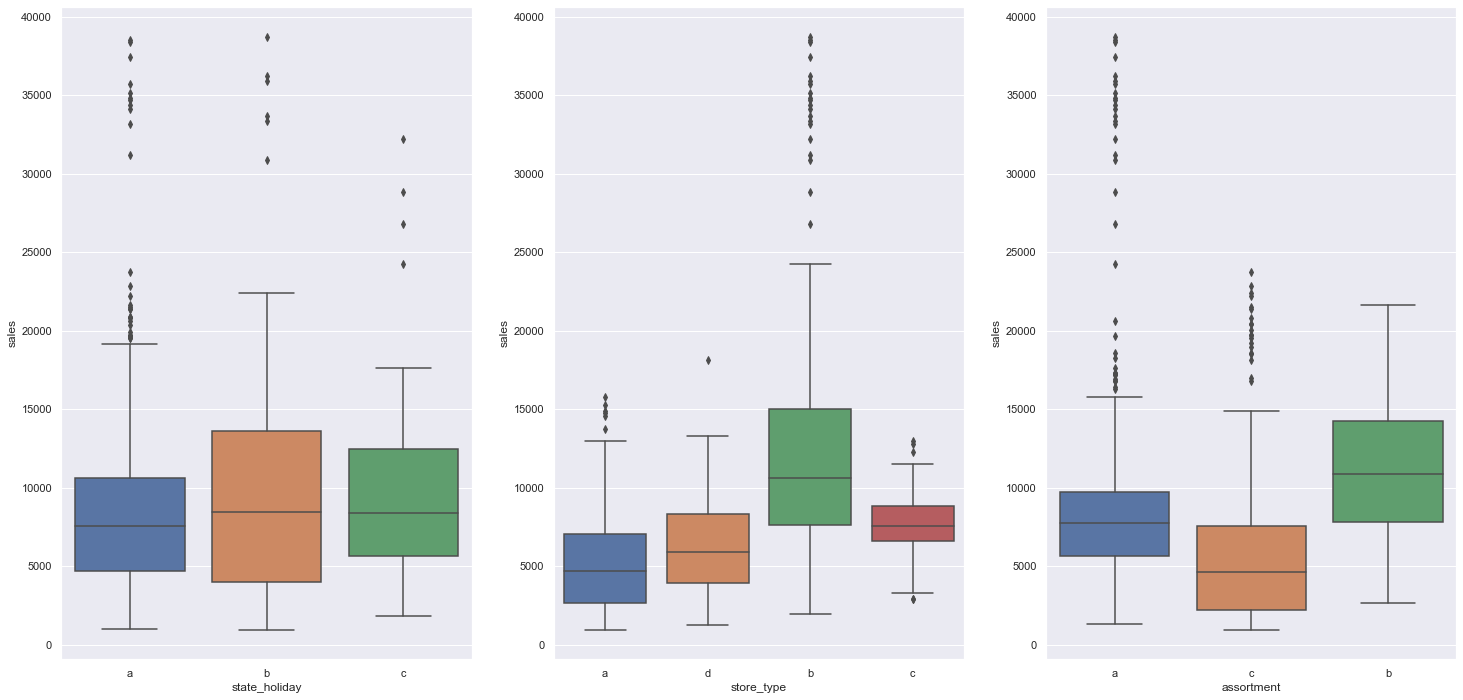

In [24]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

## Mapa mental de hipóteses
- Fenômeno:
    * Qual fenômeno estou modelando?
- Agente:
    * Quem são os agentes que atuam sobre o fenômeno de interesse?
- Attributos do Agente:
    * Qual a descrição dos agentes?
- Lista de hipóteses
    * Hipóteses para validar os dados?
    * Gerar insight: 
        * Surpresa: descobre algo novo 
        * Contrapor uma crença: quebra uma ideia formada sobre algo
